In [2]:
#               __  ___  _      __                ___              _     ___                    _      ___     _            _   _             
#              /__\/   \/_\    / _| ___  _ __    / __\__ _ _ __ __| |   / __\ __ __ _ _   _  __| |    /   \___| |_ ___  ___| |_(_) ___  _ __  
#             /_\ / /\ //_\\  | |_ / _ \| '__|  / /  / _` | '__/ _` |  / _\| '__/ _` | | | |/ _` |   / /\ / _ \ __/ _ \/ __| __| |/ _ \| '_ \ 
#            //__/ /_//  _  \ |  _| (_) | |    / /__| (_| | | | (_| | / /  | | | (_| | |_| | (_| |  / /_//  __/ ||  __/ (__| |_| | (_) | | | |
#            \__/___,'\_/ \_/ |_|  \___/|_|    \____/\__,_|_|  \__,_| \/   |_|  \__,_|\__,_|\__,_| /___,' \___|\__\___|\___|\__|_|\___/|_| |_|

Credit Card Fraud Detection is a classic class-imbalance problem where the number of fraud transactions is much lesser than the number of legitimate transaction for any bank. Most of the approaches involve building model on such imbalanced data, and thus fails to produce results on real-time new data because of overfitting on training data and a bias towards the majoritarian class of legitimate transactions. Thus, we can see this as an anomaly detection problem.

1. At what time does the Credit Card Frauds usually take place?
2. What are the general trends of amounts for Credit Card Fraud Transactions?
3. How do we balance the data to not let the model overfit on legitimate transactions?
4. Are the links an important weight to determine the output?

In [3]:
# Libraries are imported.
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.stem.snowball import SnowballStemmer
from plotly.subplots import make_subplots
from nltk.tokenize import RegexpTokenizer
from matplotlib import pyplot as plt
import plotly.graph_objects as go
from datetime import datetime
import plotly.express as px
import seaborn as sns
import pandas as pd
import numpy as np
import csv

In [4]:
# -------------------------------------------------------------------------------------------------------------------------------------------------
# -------------------------------------------------------------------> Data pre-processing <-------------------------------------------------------
# -------------------------------------------------------------------------------------------------------------------------------------------------

In [5]:
# Reading the file.
df = pd.read_csv('/Users/alejandro/Desktop/Life/Credit-Card-Fraud-Detection/Datasets/linked_master.csv', delimiter=',', encoding='utf-8', index_col=[0])
y = df['is_fraud']

In [6]:
# The first 10 rows were printed.
print(df.head(10))

  trans_date_trans_time            cc_num   
0   2020-06-21 12:14:25  2291163933867244  \
1   2020-06-21 12:14:33  3573030041201292   
2   2020-06-21 12:14:53  3598215285024754   
3   2020-06-21 12:15:15  3591919803438423   
4   2020-06-21 12:15:17  3526826139003047   
5   2020-06-21 12:15:37    30407675418785   
6   2020-06-21 12:15:44   213180742685905   
7   2020-06-21 12:15:50  3589289942931264   
8   2020-06-21 12:16:10  3596357274378601   
9   2020-06-21 12:16:11  3546897637165774   

                               merchant        category     amt     first   
0                 fraud_Kirlin and Sons   personal_care    2.86      Jeff  \
1                  fraud_Sporer-Keebler   personal_care   29.84    Joanne   
2  fraud_Swaniawski, Nitzsche and Welch  health_fitness   41.28    Ashley   
3                     fraud_Haley Group        misc_pos   60.05     Brian   
4                 fraud_Johnston-Casper          travel    3.19    Nathan   
5                   fraud_Daugherty LLC   

In [7]:
# The columns were printed.
print(df.columns)

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat',
       'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat',
       'merch_long', 'is_fraud', 'url'],
      dtype='object')


In [8]:
df.rename(columns={"trans_date_trans_time":"transaction_time",
                         "cc_num":"credit_card_number",
                         "amt":"amount(usd)",
                         "trans_num":"transaction_id"},
                inplace=True)

In [9]:
# First it is necessary to drop all the duplicate values. Although, the shell script is in charge of that.
df = df.copy()
df.drop_duplicates(inplace = True)
print("Duplicated values dropped successfully")

Duplicated values dropped successfully


In [10]:
# Some columns get renamed.
df.rename(columns = {'trans_date_trans_time':'transaction_time',
                         'cc_num':'credit_card_number',
                         'amt':'amount(usd)',
                         'trans_num':'transaction_id'},
                inplace = True)

In [11]:
# The datetime columns were converted.
# transaction_time and dob should be in pd.datetime format and we also convert unix_time to exact timestamp
df['transaction_time'] = pd.to_datetime(df['transaction_time'], infer_datetime_format = True)
df['dob'] = pd.to_datetime(df['dob'], infer_datetime_format = True)

/var/folders/1p/27jszvps12x14r9hnwf07w240000gn/T/ipykernel_96318/2465987477.py:3: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['transaction_time'] = pd.to_datetime(df['transaction_time'], infer_datetime_format = True)
/var/folders/1p/27jszvps12x14r9hnwf07w240000gn/T/ipykernel_96318/2465987477.py:4: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['dob'] = pd.to_datetime(df['dob'], infer_datetime_format = True)


In [12]:
# A function was applied utcfromtimestamp and was dropped column unix_time
df['time'] = df['unix_time'].apply(datetime.utcfromtimestamp)
df.drop('unix_time', axis=1)
# A column with hour of day was added.
df['hour_of_day'] = df.time.dt.hour

In [13]:
# Checking the time.
df[['time','hour_of_day']]

,time,hour_of_day
0,2013-06-21 12:14:25,12
1,2013-06-21 12:14:33,12
2,2013-06-21 12:14:53,12
3,2013-06-21 12:15:15,12
4,2013-06-21 12:15:17,12
...,...,...
1296670,2013-06-21 12:12:08,12
1296671,2013-06-21 12:12:19,12
1296672,2013-06-21 12:12:32,12
1296673,2013-06-21 12:13:36,12


In [14]:
# Credit card number should be integers not dtypes.
# Change dtypes.
df.credit_card_number = df.credit_card_number.astype('category')
df.is_fraud = df.is_fraud.astype('category')
df.hour_of_day = df.hour_of_day.astype('category')
# Check.
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1852394 entries, 0 to 1296674
Data columns (total 25 columns):
 #   Column              Dtype         
---  ------              -----         
 0   transaction_time    datetime64[ns]
 1   credit_card_number  category      
 2   merchant            object        
 3   category            object        
 4   amount(usd)         float64       
 5   first               object        
 6   last                object        
 7   gender              object        
 8   street              object        
 9   city                object        
 10  state               object        
 11  zip                 int64         
 12  lat                 float64       
 13  long                float64       
 14  city_pop            int64         
 15  job                 object        
 16  dob                 datetime64[ns]
 17  transaction_id      object        
 18  unix_time           int64         
 19  merch_lat           float64       
 20  merch_l

In [15]:
# -------------------------------------------------------------------------------------------------------------------------------------------------
# -------------------------------------------------------------------> End or data preprocessing <-------------------------------------------------
# -------------------------------------------------------------------------------------------------------------------------------------------------

In [16]:
# -------------------------------------------------------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------> Data cleaning <----------------------------------------------------
# -------------------------------------------------------------------------------------------------------------------------------------------------

In [17]:
# The first 10 rows were printed.
df.isnull().sum()

transaction_time      0
credit_card_number    0
merchant              0
category              0
amount(usd)           0
first                 0
last                  0
gender                0
street                0
city                  0
state                 0
zip                   0
lat                   0
long                  0
city_pop              0
job                   0
dob                   0
transaction_id        0
unix_time             0
merch_lat             0
merch_long            0
is_fraud              0
url                   0
time                  0
hour_of_day           0
dtype: int64

In [18]:
# Extracting the link and making copies. 
X = df[['url']].copy()

In [19]:
# Initialize the tokenizer, steamer and Vectorizer.
tokenizer = RegexpTokenizer(r'[A-Za-z]+')
stemmer = SnowballStemmer("english")
cv = CountVectorizer()

In [20]:
#  Prepare the data for the model.
def prepare_data(X):
    # Tokenize the text.
    X['text_tokenized'] = X.url.map(lambda t: tokenizer.tokenize(t))
    # Stem the text.
    X['text_stemmed'] = X.text_tokenized.map(lambda t: [stemmer.stem(word) for word in t])
    # Join the text.
    X['text_sent'] = X.text_stemmed.map(lambda t: ' '.join(t))
    # Vectorize the text.
    features = cv.fit_transform(X.text_sent)
    # Return the features and the target.
    return X, features
X, features = prepare_data(X)

In [21]:
print(features)

  (0, 236094)	1
  (1, 235970)	1
  (1, 188908)	1
  (1, 85545)	1
  (1, 62719)	1
  (1, 192371)	1
  (2, 235970)	1
  (2, 206324)	1
  (2, 43407)	1
  (2, 13499)	1
  (2, 96208)	1
  (3, 235970)	1
  (3, 43407)	1
  (3, 47200)	1
  (3, 159437)	1
  (4, 235970)	1
  (4, 72387)	1
  (4, 157222)	1
  (4, 44845)	1
  (4, 94329)	1
  (4, 13418)	1
  (5, 159018)	1
  (5, 126209)	1
  (5, 62984)	1
  (5, 3583)	1
  :	:
  (1852389, 173634)	1
  (1852389, 121564)	1
  (1852389, 173227)	1
  (1852390, 30765)	1
  (1852390, 193622)	1
  (1852390, 159185)	1
  (1852390, 189022)	1
  (1852390, 35322)	1
  (1852390, 121566)	1
  (1852390, 151531)	1
  (1852391, 43407)	1
  (1852391, 72760)	1
  (1852391, 121572)	1
  (1852392, 100720)	1
  (1852392, 128956)	1
  (1852392, 33035)	1
  (1852392, 69929)	1
  (1852392, 231479)	1
  (1852392, 121576)	1
  (1852393, 43407)	1
  (1852393, 159185)	1
  (1852393, 72760)	1
  (1852393, 205346)	1
  (1852393, 121577)	1
  (1852393, 179258)	1


In [22]:
# Printing the name of the columns that were created after tokenizing, steaming and vectoring.
print(X.columns)

Index(['url', 'text_tokenized', 'text_stemmed', 'text_sent'], dtype='object')


In [23]:
# Dropping link, since it is not needed.
X = X.drop('url', axis=1)
# Here it is necessary to add the features of the link to the dataset to be trained.
merged_df = pd.concat([df, X], axis=1)
# Adding the features necessary to detect the profiling fraud.
standard_features = ['transaction_id', 'hour_of_day', 'category', 'amount(usd)', 'merchant', 'job', ]
# The link features were added.
link_features = ['url', 'text_tokenized', 'text_stemmed', 'text_sent']
# All the features were merged.
all_features = standard_features + link_features
# Setting up the dataset to train as merged_df.
merged_df = merged_df[all_features].set_index("transaction_id")
# Finally, the shape got printed.
print('X shape:{}\ny shape:{}'.format(merged_df.shape,y.shape))
# The columns of the dataset are being printed.
print(merged_df.head())

X shape:(1852394, 9)
y shape:(1852394,)
                                 hour_of_day        category  amount(usd)   
transaction_id                                                              
2da90c7d74bd46a0caf3777415b3ebd3          12   personal_care         2.86  \
324cc204407e99f51b0d6ca0055005e7          12   personal_care        29.84   
c81755dbbbea9d5c77f094348a7579be          12  health_fitness        41.28   
2159175b9efe66dc301f149d3d5abf8c          12        misc_pos        60.05   
57ff021bd3f328f8738bb535c302a31b          12          travel         3.19   

                                                              merchant   
transaction_id                                                           
2da90c7d74bd46a0caf3777415b3ebd3                 fraud_Kirlin and Sons  \
324cc204407e99f51b0d6ca0055005e7                  fraud_Sporer-Keebler   
c81755dbbbea9d5c77f094348a7579be  fraud_Swaniawski, Nitzsche and Welch   
2159175b9efe66dc301f149d3d5abf8c                  

In [24]:
# -------------------------------------------------------------------------------------------------------------------------------------------------
# --------------------------------------------------------------------------> End of data cleaning <-----------------------------------------------
# -------------------------------------------------------------------------------------------------------------------------------------------------

In [25]:
# -------------------------------------------------------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------> Unbalanced data check <------------------------------------------------------
# -------------------------------------------------------------------------------------------------------------------------------------------------

In [26]:
# The  number of classes got counted, in this case, fraudulent or not.
df['is_fraud'].value_counts()

is_fraud
0    1842743
1       9651
Name: count, dtype: int64

In [27]:
# Labeling the data in genuine and fraudulent transactions, this way it is easier to observe that the data is unbalanced.
labels=["Genuine", "Fraud"]
fraud_or_not = df['is_fraud'].value_counts().tolist()
values = [fraud_or_not[0], fraud_or_not[1]]
# Plotting the values.
fig = px.pie(values = df['is_fraud'].value_counts(), names = labels , width = 700, height = 400, color_discrete_sequence = ["skyblue", "black"]
             ,title = "Fraud vs Genuine transactions")
fig.show()

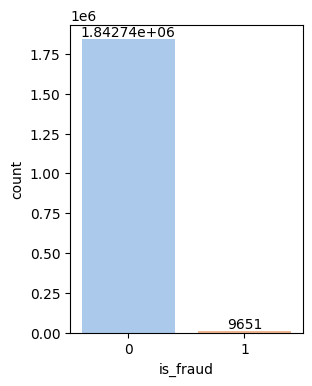

In [28]:
# Unbalance data represented with bars.
plt.figure(figsize = (3,4))
ax = sns.countplot(x = 'is_fraud', data = df, palette = "pastel")
for i in ax.containers:
    ax.bar_label(i,)

In [29]:
# Percentage of data.
print('Genuine transactions:', round(df['is_fraud'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Fraudulent transactions:', round(df['is_fraud'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

Genuine transactions: 99.48 % of the dataset
Fraudulent transactions: 0.52 % of the dataset


In [30]:
# -------------------------------------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------> Unbalanced data check was finished <--------------------------------------------------
# -------------------------------------------------------------------------------------------------------------------------------------------------

In [31]:
# -------------------------------------------------------------------------------------------------------------------------------------------------
# --------------------------------------------------------------> Exploratory Data Analysis <------------------------------------------------------
# -------------------------------------------------------------------------------------------------------------------------------------------------

In [32]:
# A quick statistical summary of the columns was made.
np.round(df.describe(), 2)

,transaction_time,amount(usd),zip,lat,long,city_pop,dob,unix_time,merch_lat,merch_long,time
count,1852394,1852394.00,1852394.00,1852394.00,1852394.00,1852394.00,1852394,1.852394e+06,1852394.00,1852394.00,1852394
mean,2020-01-20 21:31:46.801825536,70.06,48813.26,38.54,-90.23,88643.67,1973-10-15 11:05:05.744458256,1.358674e+09,38.54,-90.23,2013-01-20 09:30:18.834363392
min,2019-01-01 00:00:18,1.00,1257.00,20.03,-165.67,23.00,1924-10-30 00:00:00,1.325376e+09,19.03,-166.67,2012-01-01 00:00:18
25%,2019-07-23 04:13:43.750000128,9.64,26237.00,34.67,-96.80,741.00,1962-08-13 00:00:00,1.343017e+09,34.74,-96.90,2012-07-23 04:13:43.750000128
50%,2020-01-02 01:15:31,47.45,48174.00,39.35,-87.48,2443.00,1975-11-30 00:00:00,1.357089e+09,39.37,-87.44,2013-01-02 01:15:31
75%,2020-07-23 12:11:25.249999872,83.10,72042.00,41.94,-80.16,20328.00,1987-04-23 00:00:00,1.374581e+09,41.96,-80.25,2013-07-23 12:11:25.249999872
max,2020-12-31 23:59:34,28948.90,99921.00,66.69,-67.95,2906700.00,2005-01-29 00:00:00,1.388534e+09,67.51,-66.95,2013-12-31 23:59:34
std,NaN,159.25,26881.85,5.07,13.75,301487.62,NaN,1.819508e+07,5.11,13.76,NaN


In [33]:
# Quick Summarize using pandas_profiling was realized.
groups = [pd.Grouper(key="transaction_time", freq="1W"), "is_fraud"]
df_ = df.groupby(by=groups).agg({"amount(usd)":'mean',"transaction_id":"count"}).reset_index()

In [34]:
def add_traces(df, x, y,hue, mode, cmap, showlegend=None):
    # Name_map/HUE is the column name of the categorical variable.
    name_map = {1:"Yes", 0:"No"}
    # Create a list of traces.
    traces = []
    # Loop through the unique values of the categorical variable.
    for flag in df[hue].unique():
        # Append a trace to the list.
        traces.append(
            # Scatter plot.
            go.Scatter(
                x=df[df[hue]==flag][x],
                y=df[df[hue]==flag][y],
                mode=mode,
                # Color of the trace.
                marker=dict(color=cmap[flag]),
                showlegend=showlegend,
                name=name_map[flag]
            )
        )
    return traces

In [35]:
# Create figure with secondary y-axis.
fig = make_subplots(rows=2, cols=2,
                    specs=[
                        [{}, {}],
                        [{"colspan":2}, None]
                    ],
                    subplot_titles=("Amount(usd) over time", "Number of transactions overtime",
                                    "Number of transaction by amount(usd)")
                   )

# Add traces.
ntraces = add_traces(df=df_,x='transaction_time',y='amount(usd)',hue='is_fraud',mode='lines',
                    showlegend=True, cmap=['#61E50F','#D93C1D'])
# Add traces.
for trace in ntraces:
    fig.add_trace(
        trace,
        row=1,col=1
    )
# Add traces.
ntraces = add_traces(df=df_,x='transaction_time',y='transaction_id',hue='is_fraud',mode='lines',
                    showlegend=False, cmap=['#61E50F','#D93C1D'])
for trace in ntraces:
    fig.add_trace(
        trace,
        row=1,col=2
    )

# Add traces.
ntraces = add_traces(df=df_,x='transaction_id',y='amount(usd)',hue='is_fraud',mode='markers',
                    showlegend=True, cmap=['#61E50F','#D93C1D'])
for trace in ntraces:
    fig.add_trace(
        trace,
        row=2,col=1
    )
# Add figure title.
fig.update_layout(height=780,
                  width=960,
                  legend=dict(title='Is fraud?'),
                  plot_bgcolor='#fafafa',
                  title='Overview'
                 )

fig.show()

In [36]:
# The category of the fraudulent transactions was plotted.
df_ = df.groupby(by=[pd.Grouper(key="transaction_time", freq="1W"),
                           'is_fraud','category']).agg({"amount(usd)":'mean',"transaction_id":"count"}).reset_index()
# The category of the fraudulent transactions was plotted.
fig = px.scatter(df_,
        x='transaction_time',
        y='amount(usd)',
        color='is_fraud',
        facet_col ='category',
        facet_col_wrap=3,
        facet_col_spacing=.04,
        color_discrete_map={0:'#61E50F', 1:'#D93C1D'}
)
# The category of the fraudulent transactions was plotted.
fig.update_layout(height=1400,
                  width=960,
                  legend=dict(title='Is fraud?'),
                  plot_bgcolor='#fafafa'
                 )
fig.update_yaxes(matches=None)
fig.for_each_yaxis(lambda yaxis: yaxis.update(showticklabels=True))
fig.for_each_xaxis(lambda xaxis: xaxis.update(showticklabels=True, title=''))
fig.show();

In [37]:
# The category of the fraudulent transactions was plotted.
df_ = df.groupby(by=[pd.Grouper(key="transaction_time", freq="1M"),
                           'is_fraud','category']).agg({"amount(usd)":'sum',"transaction_id":"count"}).reset_index()

fig = px.area(
    df_[df_.is_fraud==1],
    x='transaction_time',
    y='amount(usd)',
    color='category',
    color_discrete_sequence=px.colors.qualitative.Dark24
)

fig.update_layout(height=600,
                  width=960,
                  legend=dict(title='Type of business'),
                  plot_bgcolor='#fafafa'
                 )
fig.show();

In [38]:
# Specified list of 10 business with the highest number of transactions.
top12_merchants = df.merchant.value_counts()[:12]
df_ = df.groupby(by=[pd.Grouper(key="transaction_time", freq="1W"),'is_fraud',
                           'merchant']).agg({"amount(usd)":'mean',"transaction_id":"count"}).reset_index()

# The category of the fraudulent transactions was plotted.
df_ = df_[df_.merchant.isin(top12_merchants.index)]

# The category of the fraudulent transactions was plotted.
fig = px.scatter(df_,
        x='transaction_time',
        y='amount(usd)',
        color='is_fraud',
        facet_col ='merchant',
        facet_col_wrap=3,
        facet_col_spacing=.06,
        category_orders={'merchant': top12_merchants.index}, # order the subplots
        color_discrete_map={1:'#61E50F', 0:'#D93C1D'}
)

# The category of the fraudulent transactions was plotted.
fig.update_layout(height=1200,
                  width=960,
                  title='Top 12 merchants with highest number of transactions per week',
                  legend=dict(title='Is fraud?'),
                  plot_bgcolor='#fafafa'
                 )
fig.update_yaxes(matches=None)
fig.for_each_yaxis(lambda yaxis: yaxis.update(showticklabels=True))
fig.for_each_xaxis(lambda xaxis: xaxis.update(showticklabels=True, title=''))
fig.show();

In [39]:
# Top 10 jobs had most fraud transactions.
groups = ['is_fraud','job']
df_ = df.groupby(by=groups).agg({"amount(usd)":'mean',"transaction_id":"count"}).fillna(0).reset_index()
df_ = df_[df_.is_fraud==1].sort_values(by='transaction_id',
                                       ascending=False).drop_duplicates('job', keep='first').iloc[:10, :]
df_

,is_fraud,job,amount(usd),transaction_id
880,1,Quantity surveyor,611.805652,69
806,1,Naval architect,650.121970,66
784,1,Materials engineer,561.092097,62
539,1,Audiological scientist,662.505172,58
918,1,Senior tax professional/tax inspector,570.492456,57
977,1,Trading standards officer,478.137143,56
843,1,Podiatrist,477.762593,54
691,1,Film/video editor,528.820577,52
589,1,Colour technologist,440.824706,51
685,1,Exhibition designer,524.067255,51


In [40]:
# The professions with the highest amount of fraudulent transactions were plotted.
fig = px.bar(df_,
             y='job', x='transaction_id',
             color='amount(usd)',
             color_continuous_scale=px.colors.sequential.Magma,
             labels={'job':'Job title', 
                     'transaction_id': 'Number of fraud transactions'},
             category_orders = {"job": df_.job.values},
             width=960,
             height=600)

# The colorbar was added to the plot.
fig.update_layout(
    title=dict(
        text='Amount in USD among top 10 jobs with the most fraud transactions'
    ),
    plot_bgcolor='#fafafa'
)
# The colorbar was added to the plot.
fig.update_coloraxes(
    colorbar=dict(
        title='Amount(usd) of transactions',
        orientation='h',
        x=1
    ),
    reversescale=True
)
# The plot was shown.
fig.show()

In [41]:
# Plotting the credit card numbers and card holders with the highest amount of fraudulent transactions.
groups = ['credit_card_number']
df_ = df.groupby(by=groups).agg({"amount(usd)":'mean',"transaction_id":"count"}).fillna(0).reset_index()
df_.sort_values('transaction_id', ascending=False, inplace=True)
df_ = df_.head(10)

In [42]:
# Plotting the credit card numbers and card holders with the highest amount of fraudulent transactions.
df_ = df[df.is_fraud==1].groupby(by='hour_of_day').agg({'transaction_id':'count'}).reset_index()
# Plotting the number of fraudulent transactions by hours of day.
fig = px.bar(data_frame=df_,
       x='hour_of_day',
       y='transaction_id',
       labels={'transaction_id':'Number of transaction'})
# Setting the title and background color.
fig.update_layout(
    title=dict(
        text='Number of FRAUD transactions by hours of day'
    ),
    plot_bgcolor='#fafafa'
)
# Plotting the number of fraudulent transactions by hours of day.
fig.update_xaxes(type='category')

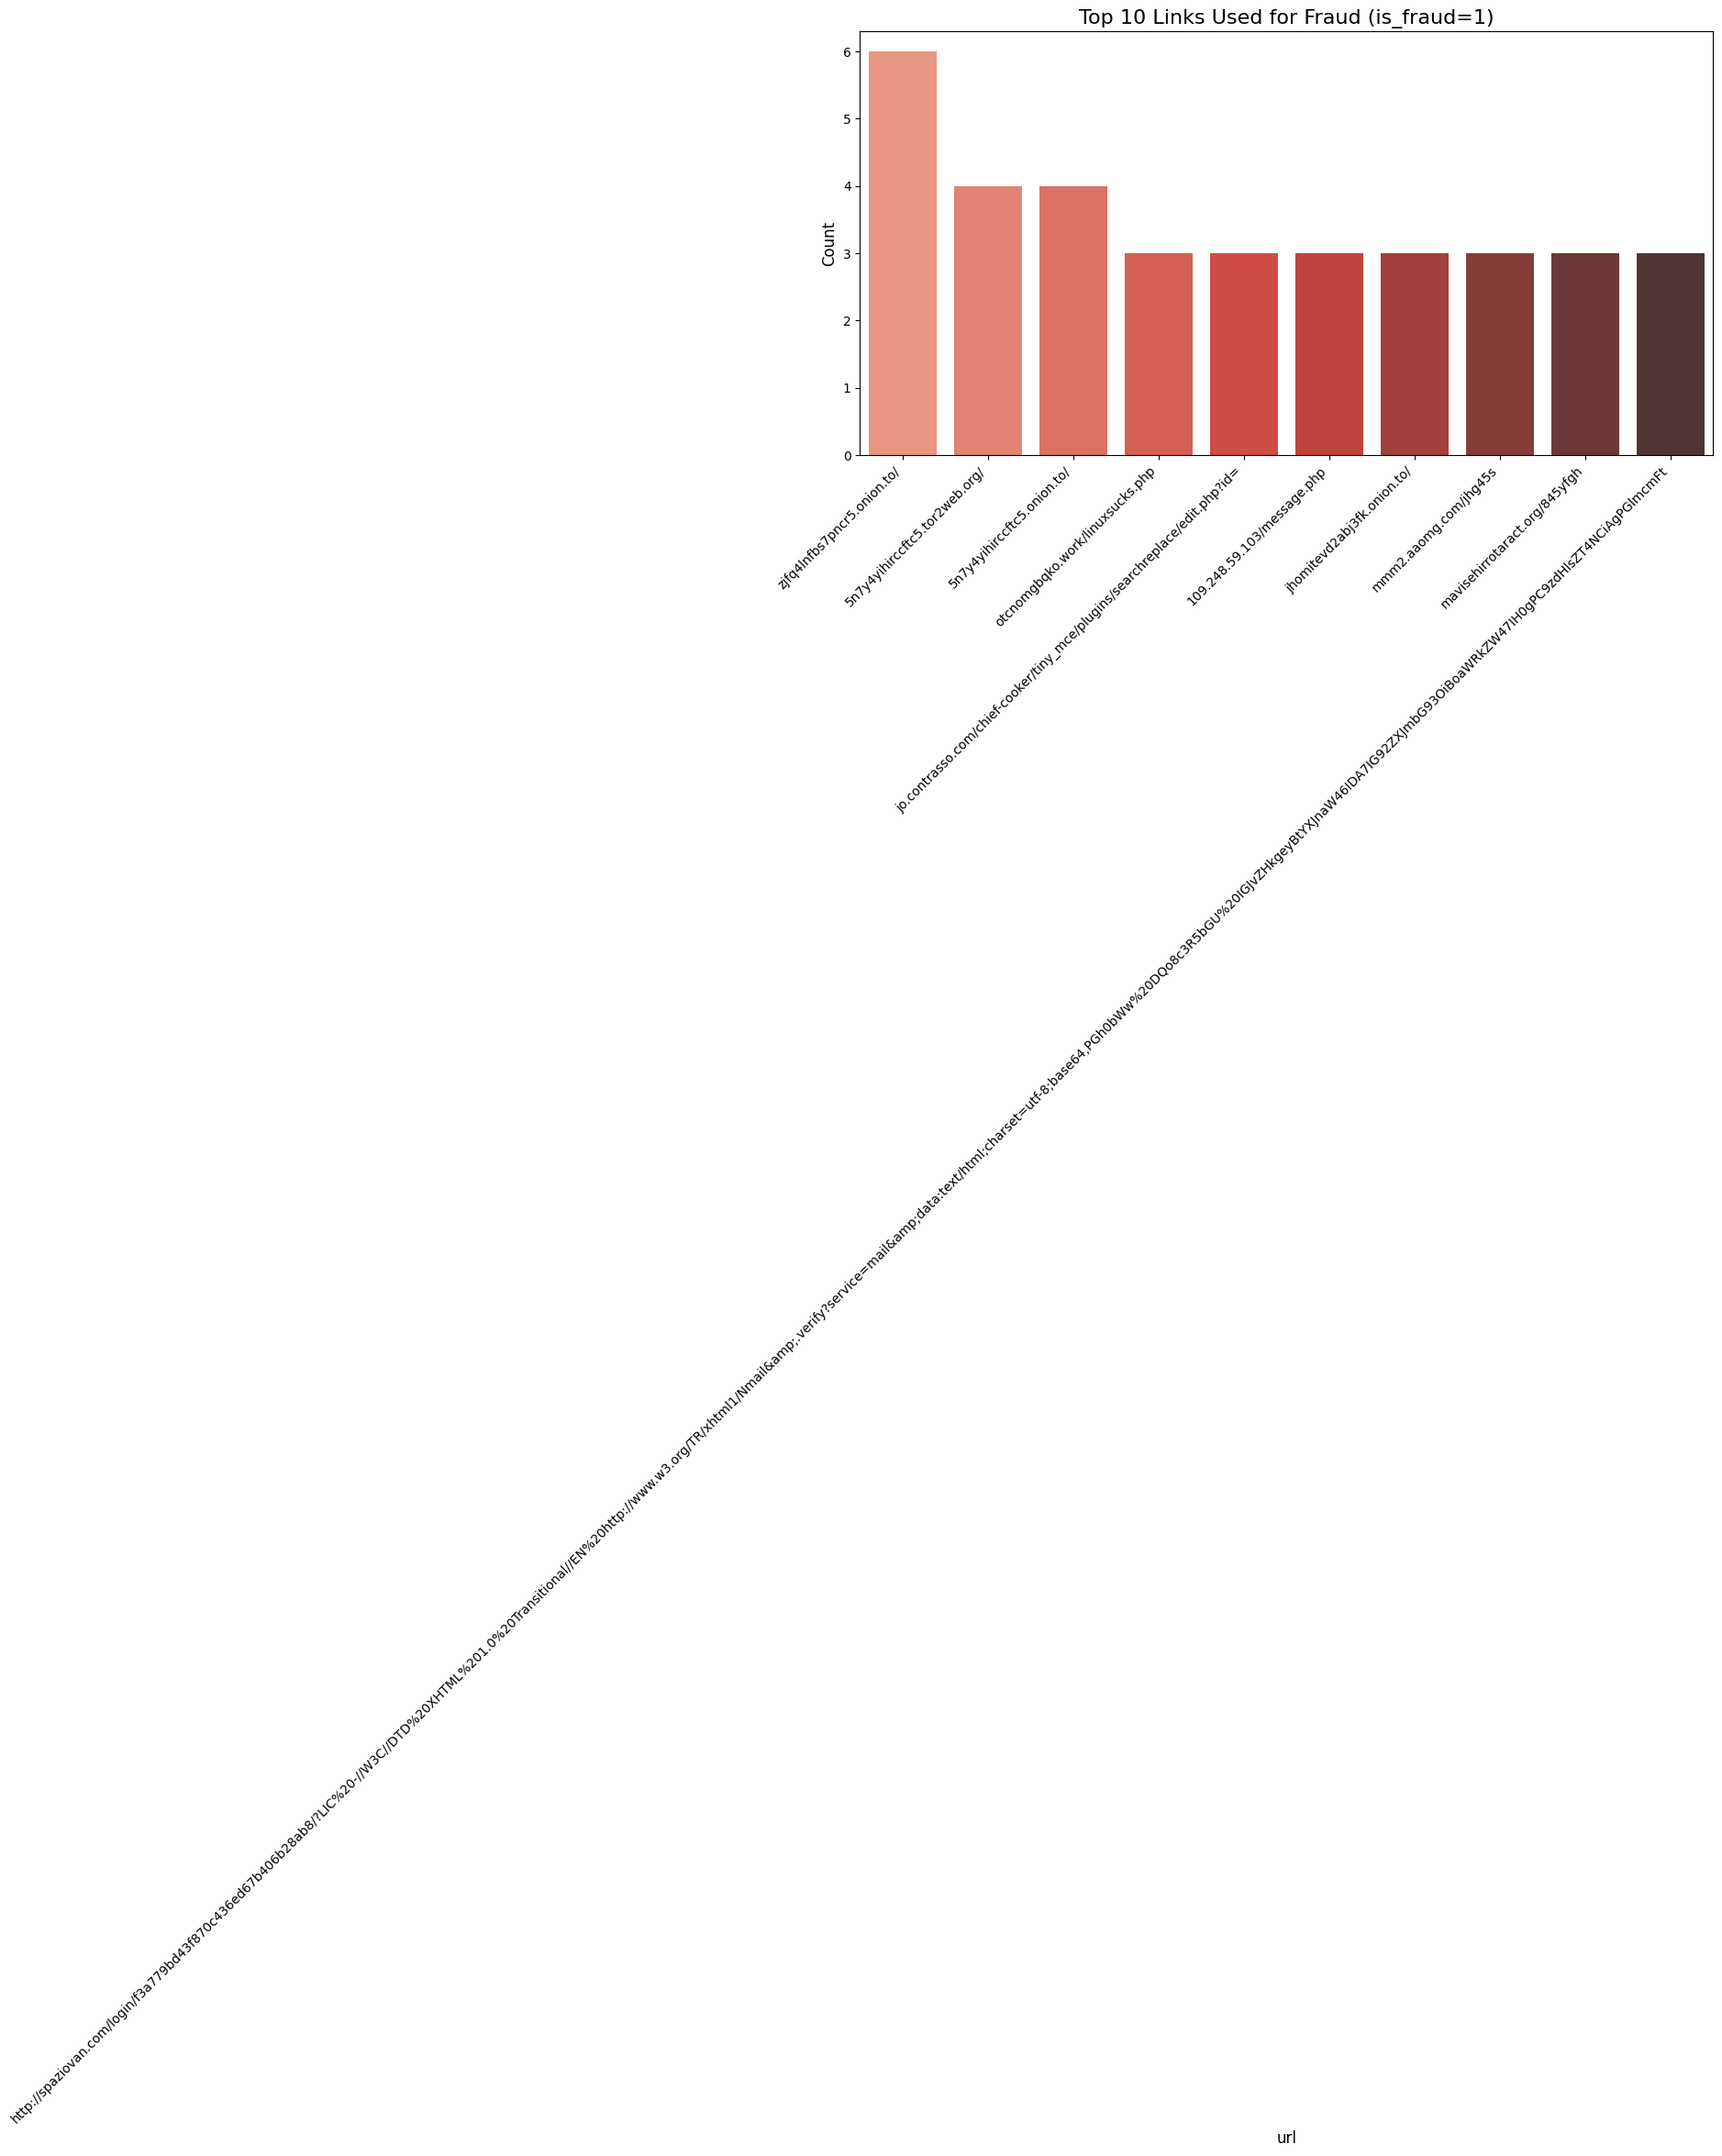

In [43]:
# Create a new DataFrame that contains the counts of each link.
df_ = df[df["is_fraud"]==1]["url"].value_counts().head(10)
# Create a bar plot of the top 10 links used for fraud.
plt.figure(figsize=(12,6))
sns.barplot(x=df_.index, y=df_.values, palette="Reds_d")
plt.title("Top 10 Links Used for Fraud (is_fraud=1)", fontsize=16)
plt.xlabel("url", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.show()

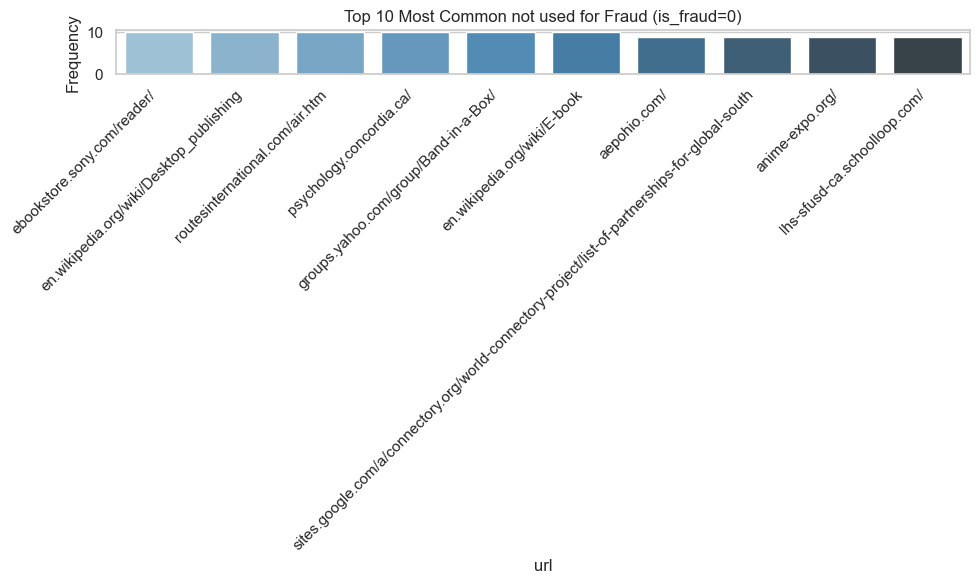

In [44]:
# Filter out the fraudulent links
df_ = df[df['is_fraud'] == 1]
# Count the occurrences of each link
link_counts = df[df['is_fraud'] == 0]['url'].value_counts()
# Select the most common links
top_links = link_counts.nlargest(10)
# Plot the data
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=top_links.index, y=top_links.values, palette="Blues_d")
plt.title("Top 10 Most Common not used for Fraud (is_fraud=0)")
plt.xlabel("url")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [45]:
df.dtypes

transaction_time      datetime64[ns]
credit_card_number          category
merchant                      object
category                      object
amount(usd)                  float64
first                         object
last                          object
gender                        object
street                        object
city                          object
state                         object
zip                            int64
lat                          float64
long                         float64
city_pop                       int64
job                           object
dob                   datetime64[ns]
transaction_id                object
unix_time                      int64
merch_lat                    float64
merch_long                   float64
is_fraud                    category
url                           object
time                  datetime64[ns]
hour_of_day                 category
dtype: object

In [46]:
# Loop through each column and attempt to convert each value to a float.
for col in df.columns:
    try:
        # Check if column contains datetime values.
        if df[col].dtype == 'datetime64[ns]':
            # Convert datetime to Unix time.
            df[col] = df[col].astype(int) / 10**9
        # Check if column contains only numeric values.
        elif pd.to_numeric(df[col], errors='coerce').notnull().all():
            df[col] = df[col].astype(float)
            print(f"Column '{col}' converted to float.")
        else:
            # Drop column if it cannot be converted to float.
            df = df.drop(col, axis=1)
            print(f"Column '{col}' contains non-numeric values and was dropped.")
    except ValueError:
        # Drop column if it cannot be converted to float.
        df = df.drop(col, axis=1)
        print(f"Column '{col}' contains a non-numeric value and was dropped.")

Column 'credit_card_number' converted to float.
Column 'merchant' contains non-numeric values and was dropped.
Column 'category' contains non-numeric values and was dropped.
Column 'amount(usd)' converted to float.
Column 'first' contains non-numeric values and was dropped.
Column 'last' contains non-numeric values and was dropped.
Column 'gender' contains non-numeric values and was dropped.
Column 'street' contains non-numeric values and was dropped.
Column 'city' contains non-numeric values and was dropped.
Column 'state' contains non-numeric values and was dropped.
Column 'zip' converted to float.
Column 'lat' converted to float.
Column 'long' converted to float.
Column 'city_pop' converted to float.
Column 'job' contains non-numeric values and was dropped.
Column 'transaction_id' contains non-numeric values and was dropped.
Column 'unix_time' converted to float.
Column 'merch_lat' converted to float.
Column 'merch_long' converted to float.
Column 'is_fraud' converted to float.
Colu

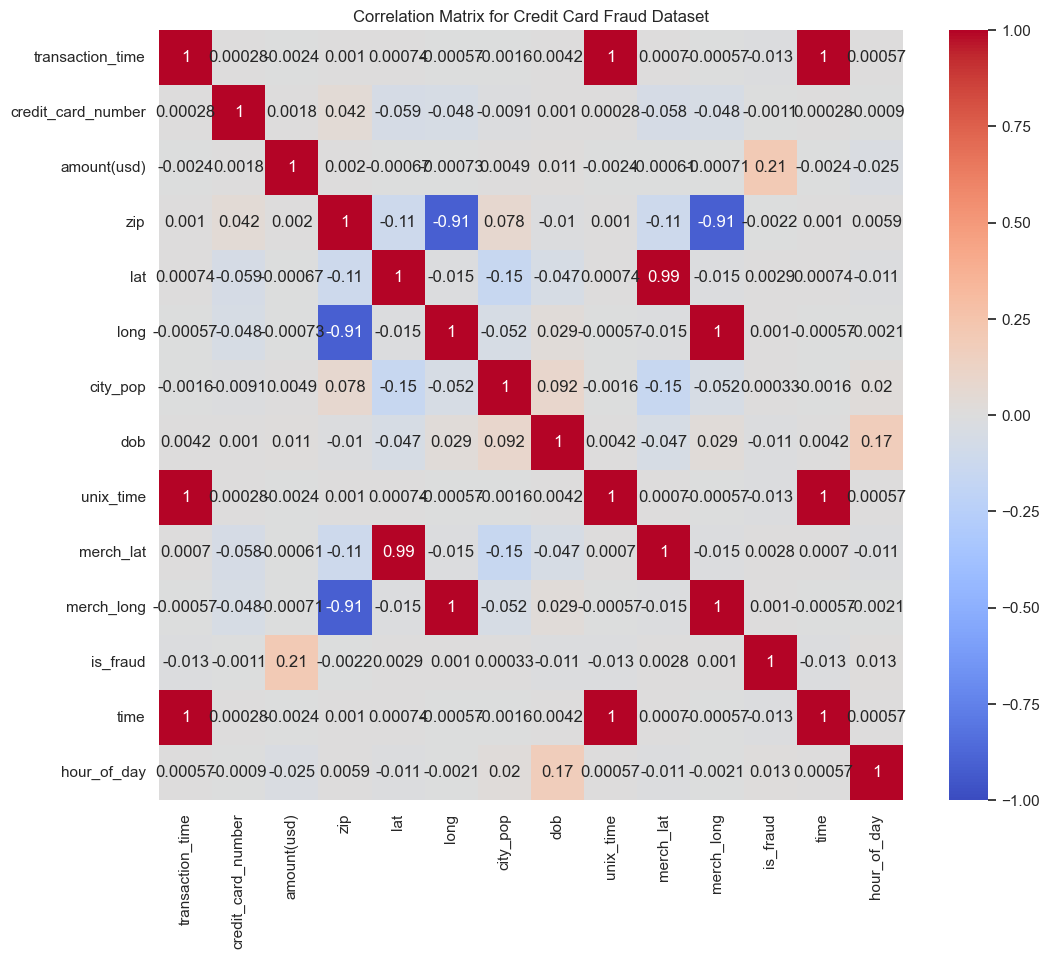

In [47]:
# Calculate the correlation matrix
corr_matrix = df.corr()
# Create a heatmap using seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix for Credit Card Fraud Dataset')
plt.show()

In [48]:
# -------------------------------------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------> SMOTE <-------------------------------------------------------------------
# -------------------------------------------------------------------------------------------------------------------------------------------------

In [49]:
# Giving the appropriate data type to each column of the dataset.
merged_df['hour_of_day'] = merged_df['hour_of_day'].astype('string') 
merged_df['category'] = merged_df['category'].astype('string')
merged_df['amount(usd)'] = merged_df['amount(usd)'].astype('float64')
merged_df['merchant'] = merged_df['merchant'].astype('string')
merged_df['job'] = merged_df['job'].astype('string')
merged_df['url'] = merged_df['url'].astype('string')
merged_df['text_tokenized'] = merged_df['text_tokenized'].astype('string')
merged_df['text_stemmed'] = merged_df['text_stemmed'].astype('string')
merged_df['text_sent'] = merged_df['text_sent'].astype('string')
# Iterate through the columns and print the data type of each column
for column in merged_df.columns:
    print('Column: {} | type: {}'.format(column, merged_df[column].dtype))

Column: hour_of_day | type: string
Column: category | type: string
Column: amount(usd) | type: float64
Column: merchant | type: string
Column: job | type: string
Column: url | type: string
Column: text_tokenized | type: string
Column: text_stemmed | type: string
Column: text_sent | type: string


In [50]:
# Importing an ordinal encoder in order to turn the categorical features into numerical.
# Leave one out encode, onehot. / Done.
# Do not encode the vectorized text.
# Do not use SKLEARN vectorizer. Maybe NKLT/Tensorflow.
# from sklearn.preprocessing import OneHotEncoder
# Replace ordinal encoding with one-hot encoding
# enc = OneHotEncoder(sparse_output=False)
# enc.fit(merged_df.loc[:,['category','merchant','job', 'url', 'text_tokenized', 'text_stemmed', 'text_sent']])
# merged_df.loc[:, ['category','merchant','job', 'url', 'text_tokenized', 'text_stemmed', 'text_sent']] = enc.transform(merged_df[['category','merchant','job', 'Link', 'text_tokenized', 'text_stemmed', 'text_sent']])

In [51]:
# Importing an ordinal encoder in order to turn the categorical features into numerical.
from sklearn.preprocessing import OrdinalEncoder
# Instantiating the encoder and fitting it to the dataset.
enc = OrdinalEncoder(dtype=np.int64)
enc.fit(merged_df.loc[:,['category','merchant','job', 'url', 'text_tokenized', 'text_stemmed', 'text_sent']])
# Transforming the categorical features into numerical.
# Here are the parameters that we will use for the final model.
merged_df.loc[:, ['category','merchant','job', 'url', 'text_tokenized', 'text_stemmed', 'text_sent']] = enc.transform(merged_df[['category','merchant','job', 'url', 'text_tokenized', 'text_stemmed', 'text_sent']])

In [52]:
from sklearn.preprocessing import StandardScaler
# Save col names
cols = merged_df.columns
# Create a StandardScaler object
scaler = StandardScaler()
# Fit the scaler to the resampled features
scaler.fit(merged_df)
# Transform the resampled features using the scaler
merged_df = scaler.transform(merged_df)
# Convert the numpy array to a pandas dataframe
merged_df = pd.DataFrame(merged_df, columns=cols)
# Print the normalized resampled features
print(merged_df)

         hour_of_day  category  amount(usd)  merchant       job       url   
0          -0.118273  0.963243    -0.421990 -0.119009  0.253070 -1.637155  \
1          -0.118273  0.963243    -0.252575  1.233877  1.089531  1.579158   
2          -0.118273 -0.314460    -0.180740  1.333353  0.139652  1.596904   
3          -0.118273  0.707702    -0.062878 -0.601471  1.202950  1.428622   
4          -0.118273  1.729865    -0.419918 -0.253302 -0.335288  1.467211   
...              ...       ...          ...       ...       ...       ...   
1852389    -0.118273 -1.592163    -0.342243  0.776283 -0.257313 -0.044743   
1852390    -0.118273 -1.336623    -0.115310 -1.695717  0.777631 -0.044726   
1852391    -0.118273 -1.336623     0.225215  1.273667  0.401932 -0.044691   
1852392    -0.118273 -1.336623     0.030369  0.826022  1.670801 -0.044631   
1852393    -0.118273 -1.336623    -0.412948  0.134657  1.543205 -0.044622   

         text_tokenized  text_stemmed  text_sent  
0             -1.700303 

In [53]:
# Separate into train and test.
df_train, df_test, y_train, y_test = train_test_split(merged_df, y, test_size=0.2, random_state=42)
# Convert df_train to a pandas dataframe
df_train = pd.DataFrame(df_train, columns=merged_df.columns)
# Print the parameters to use.
print(df_train.head())

         hour_of_day  category  amount(usd)  merchant       job       url   
1273644    -1.878901  0.707702    -0.432728  1.467647 -0.391997 -0.585665  \
601398     -1.585463 -1.081082    -0.025705 -1.491789 -0.526682 -1.183110   
999645     -0.118273 -0.058920    -0.222183 -0.049375 -0.866937 -1.112576   
1180310     0.615322 -0.058920    -0.169123 -0.049375  1.429787  1.474165   
1510522     1.055479 -0.058920    -0.395868  1.671575  1.486496  0.685649   

         text_tokenized  text_stemmed  text_sent  
1273644       -0.603666     -0.603505  -0.603206  
601398        -1.227415     -1.227463  -1.227177  
999645        -1.156410     -1.156445  -1.156150  
1180310        1.466228      1.466228   1.466542  
1510522        0.672826      0.672880   0.673188  


In [54]:
# Import the SMOTE library.
from imblearn.over_sampling import SMOTE
from collections import Counter
# Sampling and random states were specified.
# The correct sampling strategy is: sampling_strategy = {1: (1474161 / 7754) - 1} = {1: 189.8}
smote = SMOTE(sampling_strategy=0.5, random_state=42)
# Applying the SMOTE and printing the classes.
X_train_smote, y_train_smote = smote.fit_resample(df_train.astype('float'), y_train)
print("Before SMOTE:", Counter(y_train))
print("After SMOTE:", Counter(y_train_smote))

# --------------------------------------------------------------> Literature ----------------------------------------------------------------------
# "Learning from Imbalanced Data" by He et al. (https://www.cs.utah.edu/~piyush/teaching/ImbalancedLearning.pdf)
# "A systematic study of the class imbalance problem in convolutional neural networks" by Sun et al. (https://arxiv.org/abs/1710.05381)
# "Handling Imbalanced Datasets: A Review" by Fernández et al. (https://doi.org/10.1109/TEVC.2013.2296518)

Before SMOTE: Counter({0: 1474161, 1: 7754})
After SMOTE: Counter({0: 1474161, 1: 737080})


In [55]:
# -------------------------------------------------------------------------------------------------------------------------------------------------
# --------------------------------------------------------------> SMOTE FINISHED <-----------------------------------------------------------------
# -------------------------------------------------------------------------------------------------------------------------------------------------

In [56]:
# -------------------------------------------------------------------------------------------------------------------------------------------------
# --------------------------------------------------------------> TRAINING THE MODEL <-------------------------------------------------------------
# -------------------------------------------------------------------------------------------------------------------------------------------------

In [57]:
# Parsed needed to train NN.
X_train_smote = np.asarray(X_train_smote).astype(np.float32)
y_train_smote = np.asarray(y_train_smote).astype(np.float32)
df_test = np.asarray(df_test).astype(np.float32) 
y_test = np.asarray(y_test).astype(np.float32)

In [58]:
# from keras.layers import LSTM, Dense, Dropout
# from keras.models import Sequential
# from keras.callbacks import EarlyStopping

# # Define the neural network architecture
# model = Sequential()
# model.add(LSTM(128, input_shape=(X_train_smote.shape[1], 1), activation='tanh', return_sequences=True))
# model.add(Dropout(0.5))
# model.add(LSTM(256, activation='tanh'))
# model.add(Dropout(0.5))
# model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(1, activation='sigmoid'))

# # Compile the model
# model.compile(loss='binary_crossentropy', optimizer='Adagrad', metrics=['accuracy'])

# # Define early stopping
# early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# # Train the model
# model.fit(X_train_smote.reshape((X_train_smote.shape[0], X_train_smote.shape[1], 1)),
#           y_train_smote, epochs=10, batch_size=32,
#           validation_data=(df_test.reshape((df_test.shape[0], df_test.shape[1], 1)), y_test),
#           callbacks=[early_stopping])

# # Evaluate the model on the test set
# loss, accuracy = model.evaluate(df_test.reshape((df_test.shape[0], df_test.shape[1], 1)), y_test)
# print('Test loss:', loss)
# print('Test accuracy:', accuracy)
# model.save('LTSN.h5')

In [59]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
# Predict probabilities on the test set
y_prob = model.predict(df_test.reshape((df_test.shape[0], df_test.shape[1], 1)))
# Calculate precision and recall for different threshold values
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
# Plot the precision-recall curve
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
# Choose a threshold value that balances precision and recall based on the specific needs of your problem

NameError: name 'model' is not defined

In [62]:
from tensorflow.keras.models import load_model
import numpy as np


model = load_model('LTSN.h5')
# Define a function to calculate the F1 score
def f1_score(y_true, y_pred):
    tp = np.sum(np.logical_and(y_true == 1, y_pred == 1))
    fp = np.sum(np.logical_and(y_true == 0, y_pred == 1))
    fn = np.sum(np.logical_and(y_true == 1, y_pred == 0))
    precision = tp / (tp + fp + 1e-16)
    recall = tp / (tp + fn + 1e-16)
    f1 = 2 * precision * recall / (precision + recall + 1e-16)
    return f1

# Get the predicted probabilities for the test set
y_prob = model.predict(df_test.reshape((df_test.shape[0], df_test.shape[1], 1)))

# Calculate the F1 score for different threshold values
f1_scores = [f1_score(y_test, y_prob >= threshold) for threshold in thresholds]

# Find the threshold that maximizes the F1 score
optimal_threshold = thresholds[np.argmax(f1_scores)]
print('Optimal threshold:', optimal_threshold)

OSError: SavedModel file does not exist at: LTSN.h5/{saved_model.pbtxt|saved_model.pb}

In [ ]:
from sklearn.metrics import roc_curve
# Get the predicted probabilities for the test set
y_prob = model.predict(df_test.reshape((df_test.shape[0], df_test.shape[1], 1)))
# Calculate the false positive rate and true positive rate for different threshold values
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
# Calculate the Youden's J statistic for each threshold
youden_j = tpr - fpr
# Find the threshold that maximizes the Youden's J statistic
optimal_threshold = thresholds[np.argmax(youden_j)]
print('Optimal threshold:', optimal_threshold)

In [ ]:
# Define the cost matrix
cost_matrix = np.array([[0, 1], [10, 0]])

# Get the predicted probabilities for the test set
y_prob = model.predict(df_test.reshape((df_test.shape[0], df_test.shape[1], 1)))

# Calculate the confusion matrix for different threshold values
tp = np.sum(np.logical_and(y_test == 1, y_prob >= thresholds[:, None]), axis=1)
fp = np.sum(np.logical_and(y_test == 0, y_prob >= thresholds[:, None]), axis=1)
fn = np.sum(np.logical_and(y_test == 1, y_prob < thresholds[:, None]), axis=1)
tn = np.sum(np.logical_and(y_test == 0, y_prob < thresholds[:, None]), axis=1)
conf_matrix = np.array([[tn, fp], [fn, tp]])

# Calculate the expected cost for different threshold values
expected_cost = np.sum(cost_matrix * conf_matrix, axis=(1, 2))

# Find the threshold that minimizes the expected cost
optimal_threshold = thresholds[np.argmin(expected_cost)]
print('Optimal threshold:', optimal_threshold)

In [ ]:
# Define a function to calculate the F1 score
def f1_score(y_true, y_pred):
    tp = np.sum(y_true * y_pred)
    fp = np.sum((1 - y_true) * y_pred)
    fn = np.sum(y_true * (1 - y_pred))
    precision = tp / (tp + fp + 1e-16)
    recall = tp / (tp + fn + 1e-16)
    f1 = 2 * precision * recall / (precision + recall + 1e-16)
    return f1

# Get the predicted probabilities for the test set
y_prob = model.predict(df_test.reshape((df_test.shape[0], df_test.shape[1], 1)))

# Calculate the F1 score for different threshold values
y_pred = y_prob >= thresholds[:, None]
f1_scores = np.array([f1_score(y_test, y_pred[i]) for i in range(len(thresholds))])

# Find the threshold that maximizes the F1 score
optimal_threshold = thresholds[np.argmax(f1_scores)]
print('Optimal threshold:', optimal_threshold)

11578/11578 [==============================] - 68s 6ms/step


In [ ]:
import numpy as np

# Define a function to calculate the F1 score
def f1_score(y_true, y_pred):
    tp = np.sum(np.logical_and(y_true == 1, y_pred == 1))
    fp = np.sum(np.logical_and(y_true == 0, y_pred == 1))
    fn = np.sum(np.logical_and(y_true == 1, y_pred == 0))
    precision = tp / (tp + fp + 1e-16)
    recall = tp / (tp + fn + 1e-16)
    f1 = 2 * precision * recall / (precision + recall + 1e-16)
    return f1

# Get the predicted probabilities for the test set
y_prob = model.predict(df_test.reshape((df_test.shape[0], df_test.shape[1], 1)))

# Calculate the F1 score for different threshold values
f1_scores = [f1_score(y_test, y_prob >= threshold) for threshold in thresholds]

# Find the threshold that maximizes the F1 score
optimal_threshold = thresholds[np.argmax(f1_scores)]
print('Optimal threshold:', optimal_threshold)

11578/11578 [==============================] - 68s 6ms/step


: 

: 

In [ ]:
# ---------------------------------------------------> Presicion, Recall and Confusion matrix ---------------------------------------------------------------
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

# Predict on the test set
y_pred = model.predict(df_test.reshape((df_test.shape[0], df_test.shape[1], 1)))
y_pred = (y_pred > 0.93497825).astype(int)

# Calculate precision, recall, and F1 score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1_score)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix:')
print(cm)


# GOAL:
# Precision: 0.95
# Recall: 0.90
# F1 score: 0.92
# Confusion matrix:
# [[1000  10]
#  [  20  970]]

In [ ]:
# -------------------------------------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------> THE TRAINING HAS FINISHED <-----------------------------------------------------------------
# -------------------------------------------------------------------------------------------------------------------------------------------------